In [41]:
%run ../_preamble.ipynb
from _work.src.data import generate_data, create_dataloader, small_dataloader
from _work.src.models import AutoEncoder
from _work.src.modules import train_model, test_model, plot_metrics, plot_parameters, plot_tensor, get_closest_item
from _work.src.modules.replay import recirculate
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch

In [42]:
dataloader = small_dataloader

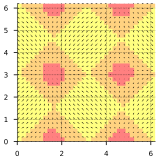

In [32]:
from matplotlib import colors

X, Y = np.meshgrid(np.arange(0, 2 * np.pi, .2), np.arange(0, 2 * np.pi, .2))
U = np.cos(X)
V = np.sin(Y)
speed = np.sqrt(U*U + V*V)

cmap = colors.ListedColormap(['red', 'orange', 'yellow'])
boundaries = [0, 0.5, 1, 1.5]
norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)

plt.imshow(speed, extent=[X.min(), X.max(), Y.min(), Y.max()], alpha=0.5, cmap=cmap, norm=norm)

plt.quiver(X, Y, U, V, units='width')
# plt.scatter(X, Y, s=2);

## Undercomplete

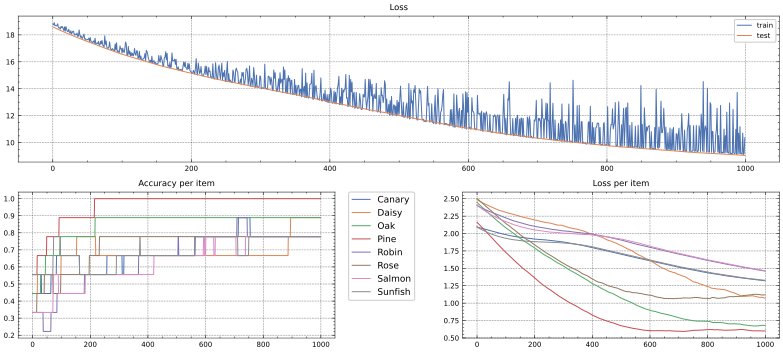

In [15]:
HIDDEN_SIZE = 2

metrics = train_model(
    model := AutoEncoder(
        sizes=[dataloader.dataset.NUM_ATTRIBUTES, HIDDEN_SIZE],
        batch_norm=False,
        F=torch.nn.LeakyReLU,
        dropout=0.15,
    ),
    optimizer := torch.optim.Adam(model.parameters(), lr=1e-3),
    loss_fn := torch.nn.MSELoss(reduction="sum"),
    dataloader,
    epochs=1000,
    l1_lambda=0.005,
    noise_mean=0,
    noise_stdev=1,
)

plot_metrics(metrics);

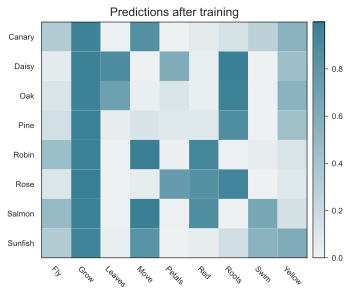

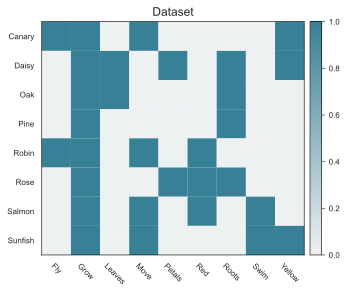

In [25]:
model.eval()
outs = []
with torch.no_grad():
    for b in dataloader.dataset:
        out = model(b['y'])
        outs.append(out.squeeze().tolist())
ax = plot_tensor(pd.DataFrame(outs, index=dataloader.dataset.df.index, columns=dataloader.dataset.df.columns));
ax.set_title("Predictions after training");
axx = plot_tensor(dataloader.dataset.df);
axx.set_title("Dataset");

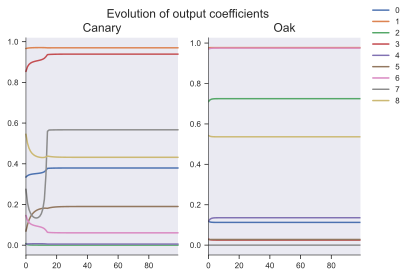

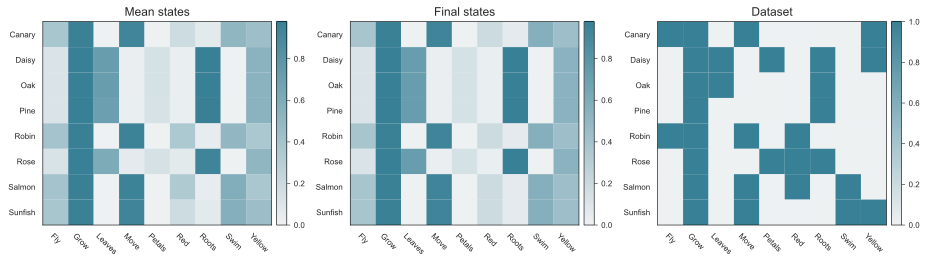

In [26]:
chain = recirculate(model, dataloader, mean=0, sd=0, steps=100, runs=1)
canary = np.array(chain['Canary'])
oak = np.array(chain['Oak'])

fig, axes = plt.subplots(ncols=2)
for i in range(len(canary[0])):
    axes[0].plot(canary[:, i], label=i)
    axes[1].plot(oak[:, i], label=i)
axes[0].set_title("Canary")
axes[1].set_title("Oak")
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels);
fig.suptitle("Evolution of output coefficients");

means = { k: np.mean(v, axis=0) for k, v in chain.items() }
finals = { k: v[-1] for k, v in chain.items() }
fig, axes = plt.subplots(ncols=3, figsize=(13, 5))
plot_tensor(pd.DataFrame(means, index=dataloader.dataset.df.columns).transpose(), ax=axes[0]);
axes[0].set_title("Mean states");
plot_tensor(pd.DataFrame(finals, index=dataloader.dataset.df.columns).transpose(), ax=axes[1]);
axes[1].set_title("Final states");
plot_tensor(dataloader.dataset.df, ax=axes[2]);
axes[2].set_title("Dataset");

In [50]:
@torch.no_grad()
def iterate(input=None, mean=0, stdev=2, runs=1, steps=10):
    model.eval()

    activations = []
    def save_hook():
        def hook(model, input, output):
            activations.append(input[0].detach().numpy())
        return hook

    layer = dict(model.named_modules())['decoder.linear1']
    hook = layer.register_forward_hook(save_hook())

    states = []
    for run in range(runs):
        if input is None:
            input = torch.rand(dataloader.dataset.NUM_ATTRIBUTES)
        states.append([input])

        for _ in range(steps):
            output = model(input)

            states[run].append(output)

            input = output
            input[input > 1] = 1
            input[input < 0] = 0
    
    hook.remove()
    return states, activations

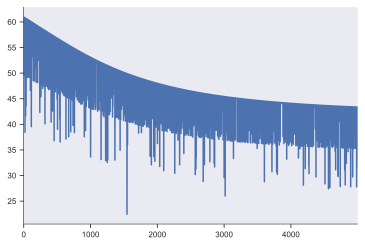

In [82]:
states, activations = iterate(runs=5, steps=50)
activations = [x.squeeze() for x in activations]
# for state in states:
#     plot_tensor(torch.vstack([state[0], state[-1]]))

second_model = AutoEncoder(
    sizes=[len(activations[0]), HIDDEN_SIZE],
    batch_norm=False,
    dropout=0.15,
)
loss_fn = torch.nn.MSELoss(reduction="sum")
optimizer = torch.optim.Adam(second_model.parameters(), lr=1e-3)

losses = []
for _ in range(5000):
    rand_idx = np.random.choice(range(len(activations)), size=4, replace=False)
    y = torch.tensor([activations[i] for i in rand_idx]).squeeze()

    y_pred = second_model(y)

    loss = loss_fn(y_pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

plt.plot(losses);

In [81]:
from scipy.interpolate import interp2d

colormap = {
    "Robin": "#e57373",
    "Sunfish": "#FDD500",
    "Oak": "#81c784",
    "Pine": "#2e7d32",
    "Canary": "#FFF402",
    "Daisy": "#FEA401",
    "Salmon": "#ff4081",
    "Rose": "#dd2c00",
}

@torch.no_grad()
def plot_grid():
    attractors = torch.vstack([model.encoder(x['y']) for x in dataloader.dataset])

    xs = attractors[:, 0]
    ys = attractors[:, 1]

    xmax, xmin = xs.max(), xs.min()
    ymax, ymin = ys.max(), ys.min()
    xrange, yrange = abs(xmax - xmin), abs(ymax - ymin)
    xpad, ypad = xrange/6, yrange/6

    x = np.linspace(xmin - xpad, xmax + xpad, num=100)
    y = np.linspace(ymin - ypad, ymax + ypad, num=100)
    xg, yg = np.meshgrid(x, y)

    z = []
    zx, zy = [], []
    for x, y in zip(xg.ravel(), yg.ravel()):
        y_pred = model.decoder(activ := torch.tensor([x, y], dtype=torch.float32))
        item = get_closest_item(dataloader.dataset.df, y_pred, metric="euclidean")

        z.append(item[0])

        _, activations = iterate(input=y_pred, runs=1, steps=100)
        final_activ = activations[-1].squeeze()
        diff = np.subtract(final_activ, activ)
        zx.append(diff[0])
        zy.append(diff[1])
    
    cmap = colors.ListedColormap([*colormap.values()])
    classes = np.array([list(colormap.keys()).index(x) for x in z]).reshape(xg.shape)
    plt.pcolormesh(xg, yg, classes, cmap=cmap, alpha=0.5, shading='nearest')

    i = 4
    zx = np.array(zx).reshape(xg.shape)
    zy = np.array(zy).reshape(yg.shape)
    plt.scatter(xg[::i, ::i], yg[::i, ::i], c=classes[::i, ::i], cmap=cmap, alpha=0.75, s=2)
    plt.quiver(xg[::i, ::i], yg[::i, ::i], zx[::i, ::i], zy[::i, ::i], alpha=0.75, units='xy')

    # plt.scatter(xg, yg)
    for i, item in enumerate(attractors):
        plt.scatter(item[0], item[1], color=colormap[dataloader.dataset.df.index[i]], edgecolors='black', marker='*', s=100)

plot_grid()

## Replay

In [6]:
from scipy.spatial.distance import cdist

In [153]:
def idx_of_closest_example(T_, i):
    dists = cdist([T_[i]], T_)
    dists[0][i] = np.inf # exclude the item itself
    mins = np.where(dists == dists.min())[1]

    if len(mins) == 0:
        mins = np.random.choice(range(len(T_)), 1)
    
    idx = np.random.choice(mins, 1).item()
    return idx


def munge(T: list[list[int]], k: int, p: float):
    D = []

    for _ in range(k):
        T_ = T.tolist() if hasattr(T, 'tolist') else list(T)

        for i, e in enumerate(T_):
            idx = idx_of_closest_example(T_, i)
            e_ = T_[idx]

            for j, _ in enumerate(e):
                swap = np.random.choice([True, False], p=[p, 1 - p])

                if swap == True:
                    temp = e[j]
                    e[j] = e_[j]
                    e_[j] = temp

        D.extend(T_)
    
    return D


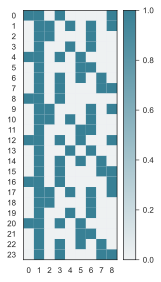

In [151]:
plot_tensor(munge(dataloader.dataset.df.values, 3, 0.1));